In [1]:
import pandas as pd
import numpy as np

# hidpi figures
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

The data file is expected to have a format like this:
```
% head muon_data_20241101_1806.csv
baseline,stddev,threshold,reset_threshold,run_start_time,is_leader
775.0, 9.3, 975, 825, 2024-11-01T18:06:41.482495-04:00, 1
Muon Count,ADC,temperature_ADC,dt,t,t_wait,coinc
1, 7089, 15171, 2, 20751, 76, 0
2, 5313, 15171, 240, 20991, 78, 0
3, 1024, 15171, 580, 21571, 93, 0
```
Metadata about the run in the first two lines, then the header for the actual data, followed by the data.

First, read in the first two rows of the CSV file: they contain metadata about the run itself. Start time, thresholds, if the device is the 'leader'.

Put the file name in here.

In [3]:
#filename='muon_data_20241101_1806.csv'
filename='/Users/wittich/Downloads/muon_data_20241211_1030.csv'

mdf = pd.read_csv(filename, nrows=1,sep=',',engine='python')
print(mdf.head())

mdf.keys()
run_start_time = mdf['run_start_time'][0]
print("run started at", run_start_time)

   baseline  stddev  threshold  reset_threshold  \
0     740.2    15.0       1740              790   

                      run_start_time  is_leader  
0   2024-12-11T10:30:46.960730-05:00          1  
run started at  2024-12-11T10:30:46.960730-05:00


Skipping the first two rows which contain the metadata,read in the rest of the CSV file. 
Concert the two ADC counts to volts and temperature, respectively.

In [4]:
df = pd.read_csv(filename,sep=',',engine='python', skiprows=2)
print(df.keys())
if 'Muon Count' in df.keys():
    df=df.drop(columns=['Muon Count'])
print(len(df))
df['V'] = df['ADC']*3.3/(2**16-1)
## Convert 16-bit ADC value to degrees C for a TMP36 temperature sensor -- Rev2
#df['TempC'] = (df['temperature_ADC']*3.3/65536)/.01 + (25-75)
# Rev 3 -- TMP235 sensor
# data sheet page 8, T_A = (V_OUT - V_OFFSET)/T_C + T_INFL
# for the TMP235, V_OUT = T_C = 10 mV/degC and V_OFFSET = 500 mV, for 
# the temperature range -40C to 100C. T_INFL = 0
T_INFL = 0.
T_C = 0.01 # 10 mV/degC
V_OFFSET = 0.5 # 500 mV
df['TempC'] = ((df['temperature_ADC']*3.3/65536)  - V_OFFSET)/T_C + T_INFL
df.head()

Index(['Muon Count', 'ADC', 'temperature_ADC', 'dt', 't', 't_wait', 'coinc'], dtype='object')
5640


,ADC,temperature_ADC,dt,t,t_wait,coinc,V,TempC
0,27718,14499,9520,282177,58,0,1.395734,23.008270
1,1808,14547,1441,283618,107,0,0.091041,23.249969
2,8177,14515,1553,285171,76,0,0.411751,23.088837
3,1760,14515,6940,292111,102,0,0.088624,23.088837
4,4625,14531,3041,295152,77,0,0.232891,23.169403


We now use the metadata to put some sort of absolute time into the data file. 

In [5]:
# convert the timestamp to use it to turn the ms times into wall clock times. Likely not very precise -- within a second --  but shruggie emoji
tstart = pd.to_datetime(run_start_time, format='ISO8601')
print(tstart)
# now remove the offset and set the t variable to start at 0 for the first line of the table
df['t'] = df['t'] - df['t'].iloc[0]


2024-12-11 10:30:46.960730-05:00


In [6]:
if 'tstart' in locals() and tstart is not None:
    df['time'] = pd.to_datetime(df['t'], unit='ms', origin=tstart.tz_localize(None))
else:
    df['time'] = pd.to_datetime(df['t'], unit='ms')
df.set_index('time',inplace=True)
# drop the dt column, no longer needed
df.drop(columns='dt',inplace=True)
df.head()

,ADC,temperature_ADC,t,t_wait,coinc,V,TempC
time,,,,,,,
2024-12-11 10:30:46.960,27718,14499,0,58,0,1.395734,23.008270
2024-12-11 10:30:48.401,1808,14547,1441,107,0,0.091041,23.249969
2024-12-11 10:30:49.954,8177,14515,2994,76,0,0.411751,23.088837
2024-12-11 10:30:56.894,1760,14515,9934,102,0,0.088624,23.088837
2024-12-11 10:30:59.935,4625,14531,12975,77,0,0.232891,23.169403


In [7]:
# add a column for the coincidence counter, if it doesn't exist (for older data files)
if 'coinc' not in df.columns:
    df['coinc'] = 0

In [8]:
df.keys()

Index(['ADC', 'temperature_ADC', 't', 't_wait', 'coinc', 'V', 'TempC'], dtype='object')

Look at the correlation between t_wait and the measured threshold. 

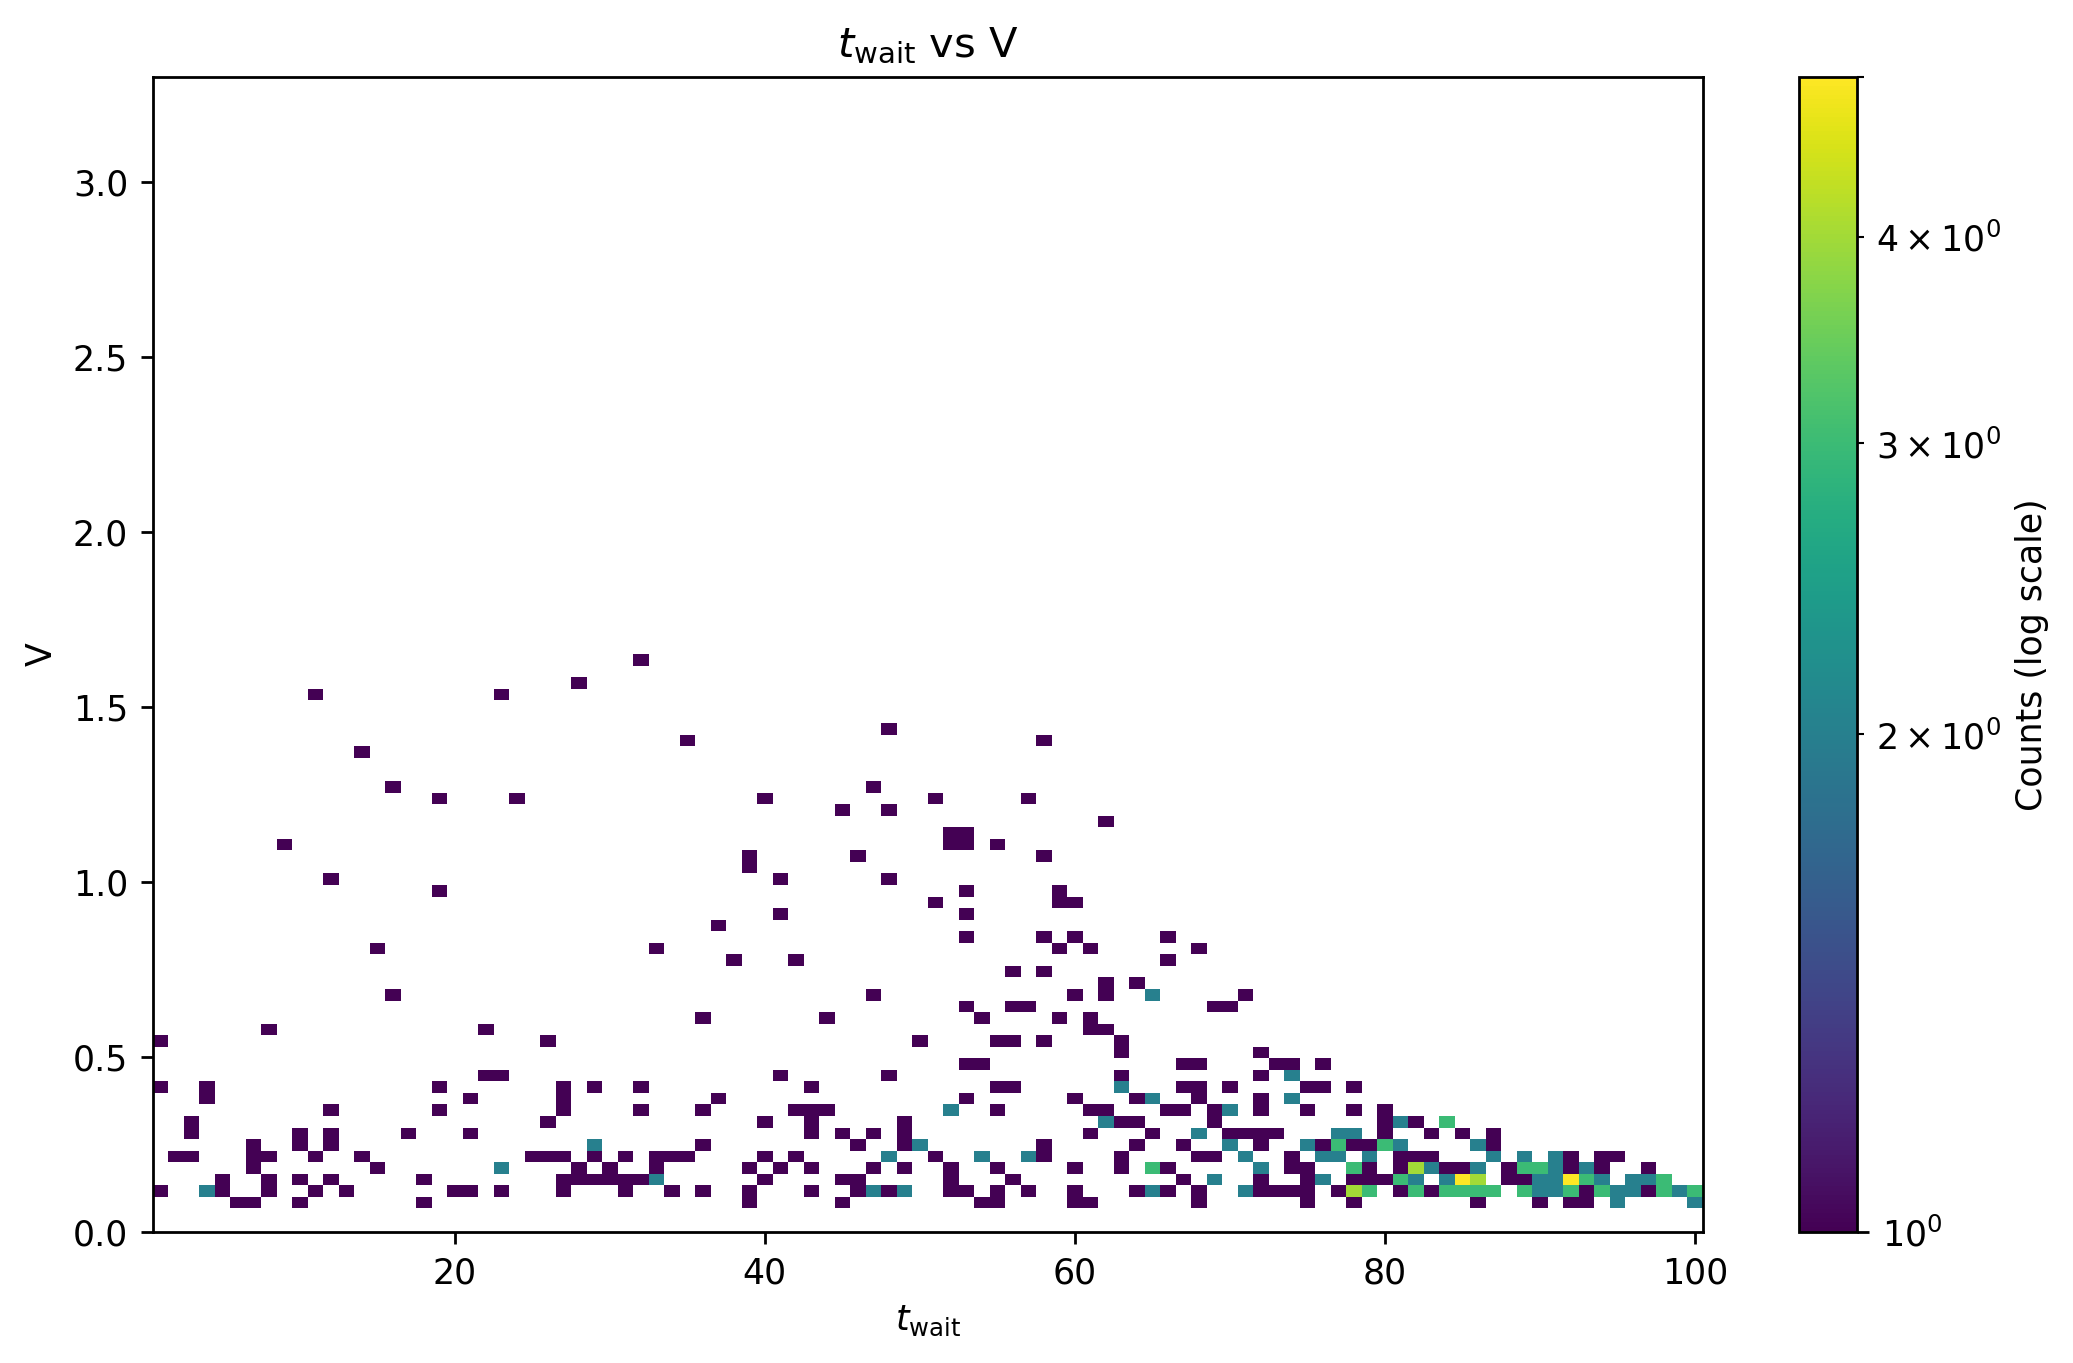

In [9]:
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 6))
tedges = np.linspace(30.5, 100.5, 71)
tedges = np.linspace(0.5, 100.5, 101)
vedges = np.linspace(0, 3.3, 101)
plt.hist2d(df['t_wait'], df['V'], bins=[tedges, vedges],   norm=mcolors.LogNorm())
plt.colorbar(label='Counts (log scale)')
plt.xlabel('$t_\\text{wait}$')
plt.ylabel('V')
plt.title('$t_\\text{wait}$ vs V')
plt.show()

# Create two different subsets of the full data file:
## dfc
This is the dataframe with a twait cut. this uses $t_{wait}$ as a proxy for the time it takes to return to baseline; should reject noise injected after the peak detector. Choose t_wait cut based on the plot above.

Note that twait is odd: it starts at 100 and counts downward. so t_wait is 60 means the code waited 40 loop iterations (100-60).
## dfcc 
This is the file with a coincidence requirement between two detectors. Should reject singles rate.

Total entries: 5640, Entries with twait < 60: 5322


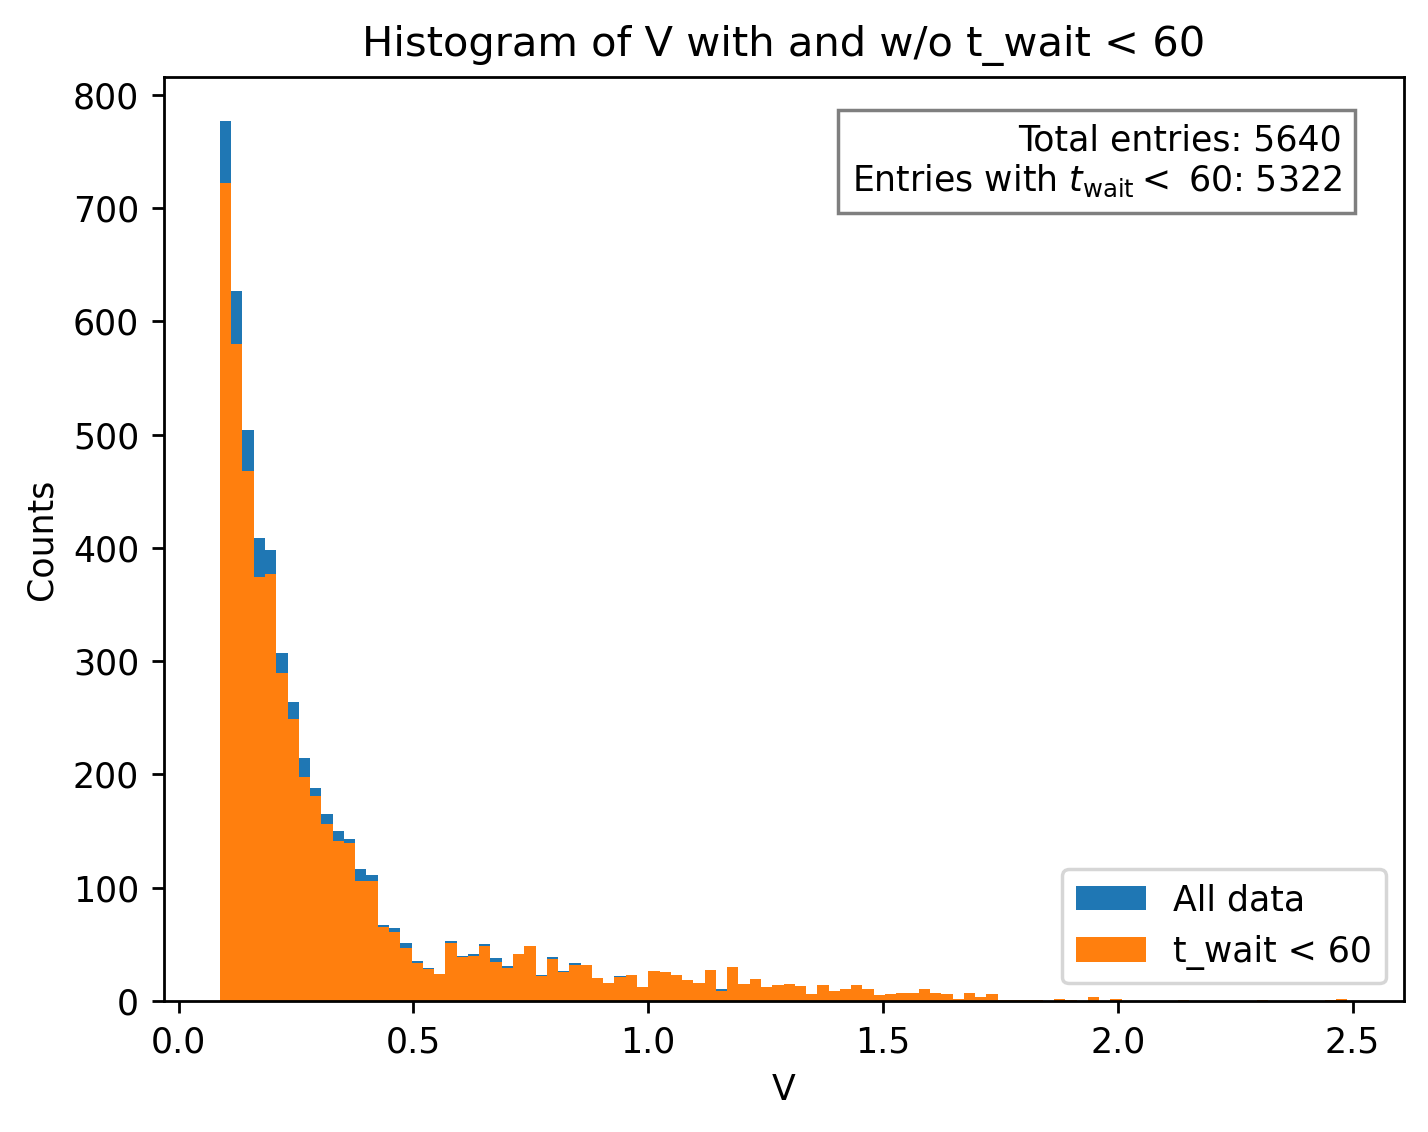

<Figure size 1600x1200 with 0 Axes>

In [10]:
cut = 60
dfc = df[df['t_wait'] < cut].copy()
df['V'].plot.hist(bins=100)
dfc['V'].plot.hist(bins=100)
plt.xlabel('V')
plt.ylabel('Counts')
plt.title(f'Histogram of V with and w/o t_wait < {cut}')
plt.legend(['All data', f't_wait < {cut}'])
total_entries = len(df)
cut_entries = len(df[df['t_wait'] < cut])
print(f'Total entries: {total_entries}, Entries with twait < {cut}: {cut_entries}')
plt.text(0.95, 0.95, f'Total entries: {total_entries}\nEntries with $t_\\text{{wait}}<$ {cut}: {cut_entries}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.show()
plt.savefig('V_hist.png')


Total entries: 5640, Entries with coincidence: 0


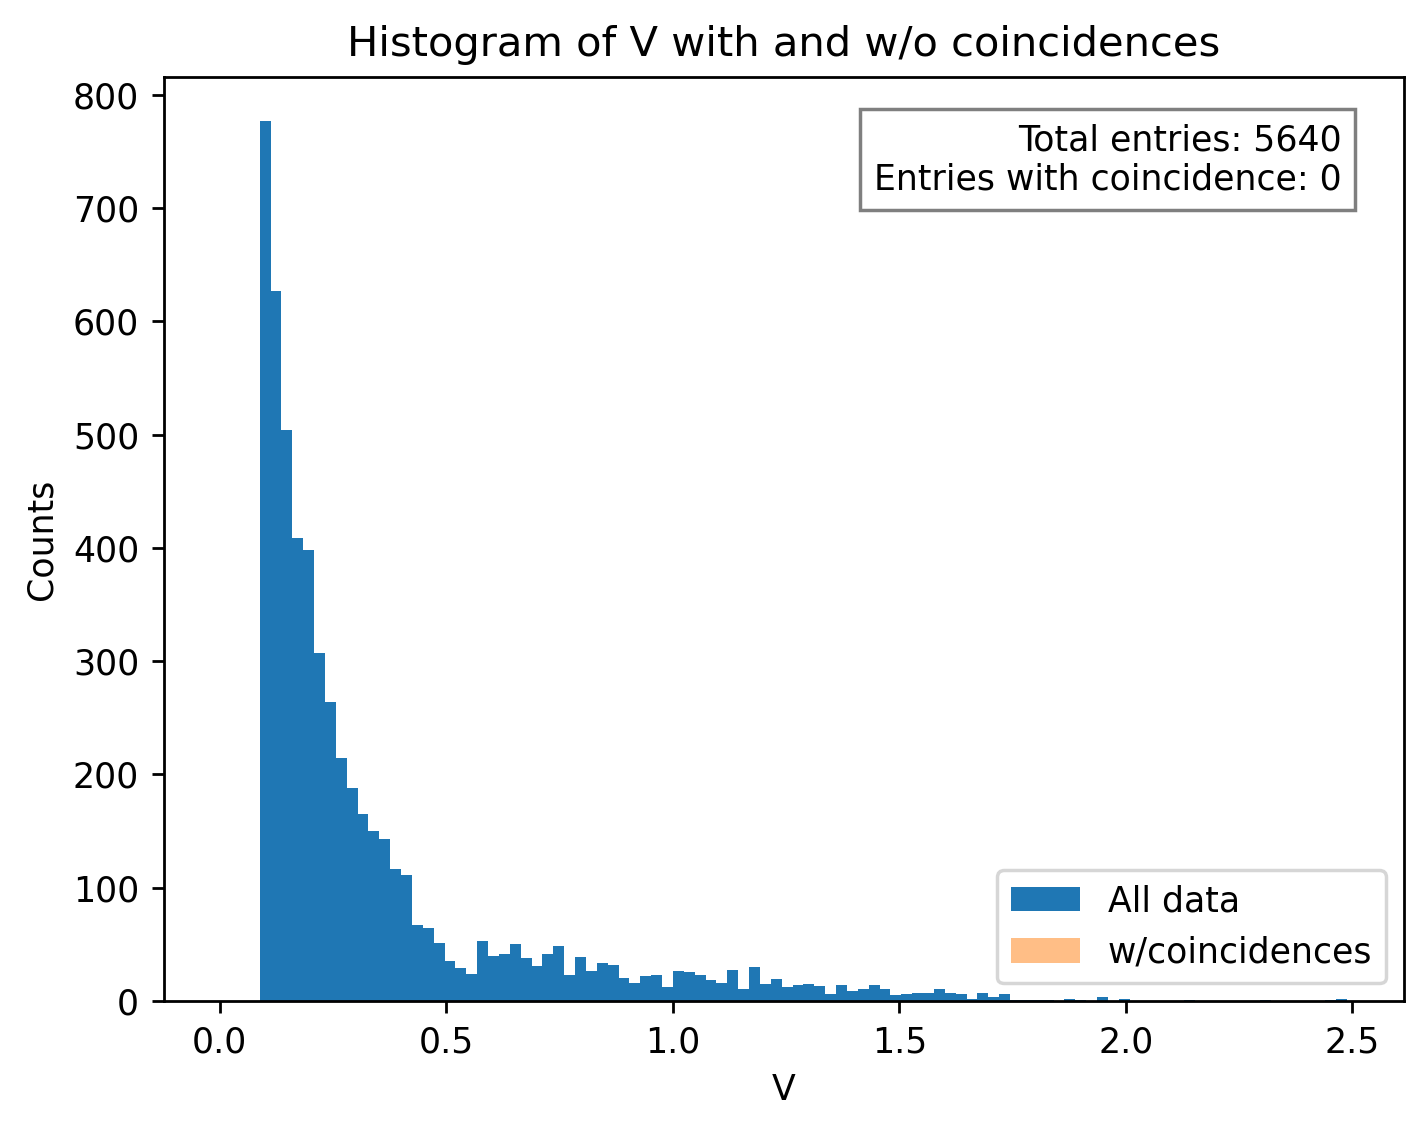

<Figure size 1600x1200 with 0 Axes>

In [ ]:
dfcc = df[df['coinc'] >0].copy()
df['V'].plot.hist(bins=100)
dfcc['V'].plot.hist(bins=100, alpha=0.5)
plt.xlabel('V')
plt.ylabel('Counts')
plt.title('Histogram of V with and w/o coincidences')
plt.legend(['All data', 'w/coincidences'])
total_entries = len(df)
cut_entries = len(dfcc)
print(f'Total entries: {total_entries}, Entries with coincidence: {cut_entries}')
plt.text(0.95, 0.95, f'Total entries: {total_entries}\nEntries with coincidence: {cut_entries}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.show()
plt.savefig('V_hist_coinc.png')

Total entries: 5640, Entries with coincidence: 0


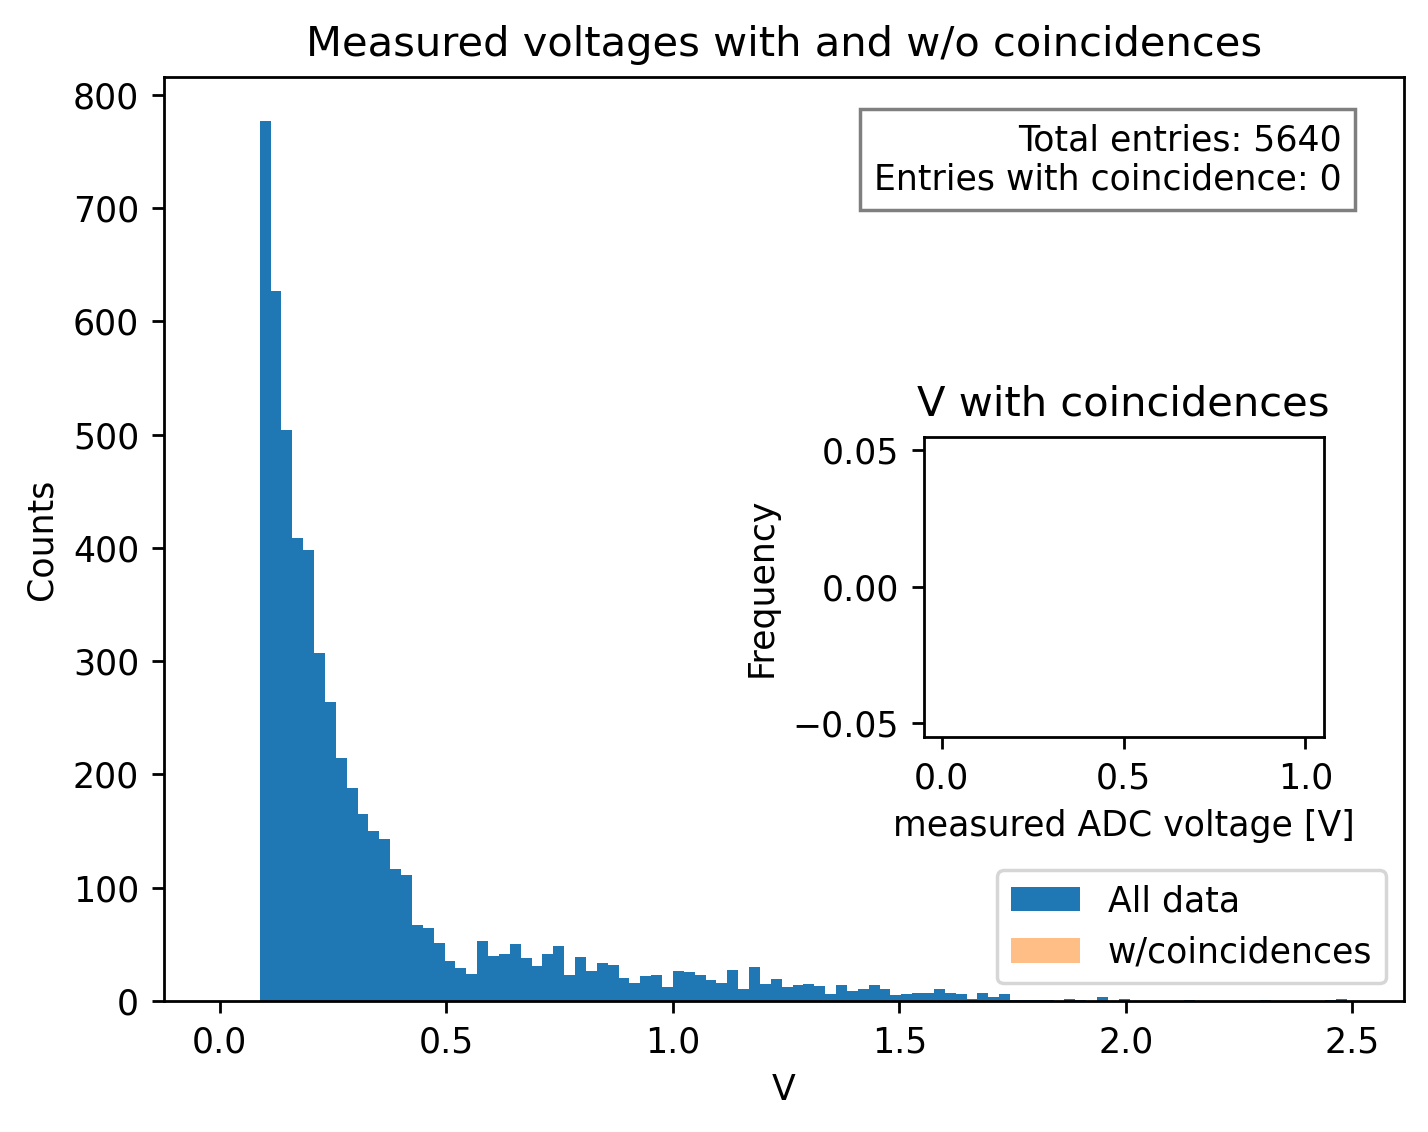

<Figure size 1600x1200 with 0 Axes>

In [ ]:
dfcc = df[df['coinc'] >0].copy()
df['V'].plot.hist(bins=100)
dfcc['V'].plot.hist(bins=100, alpha=0.5)
plt.xlabel('V')
plt.ylabel('Counts')
plt.title('Measured voltages with and w/o coincidences')
plt.legend(['All data', 'w/coincidences'])
total_entries = len(df)
cut_entries = len(dfcc)
print(f'Total entries: {total_entries}, Entries with coincidence: {cut_entries}')
plt.text(0.95, 0.95, f'Total entries: {total_entries}\nEntries with coincidence: {cut_entries}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
# add an inset with the histogram of the coincidences
axin = plt.axes([0.6, 0.33, 0.25, 0.25])
dfcc['V'].plot.hist(bins=100, color='C1', ax=axin)
plt.title('V with coincidences')
plt.xlabel('measured ADC voltage [V]')
plt.show()
plt.savefig('V_hist_coinc_inset.png')

Compare the two ways of rejecting noise. 

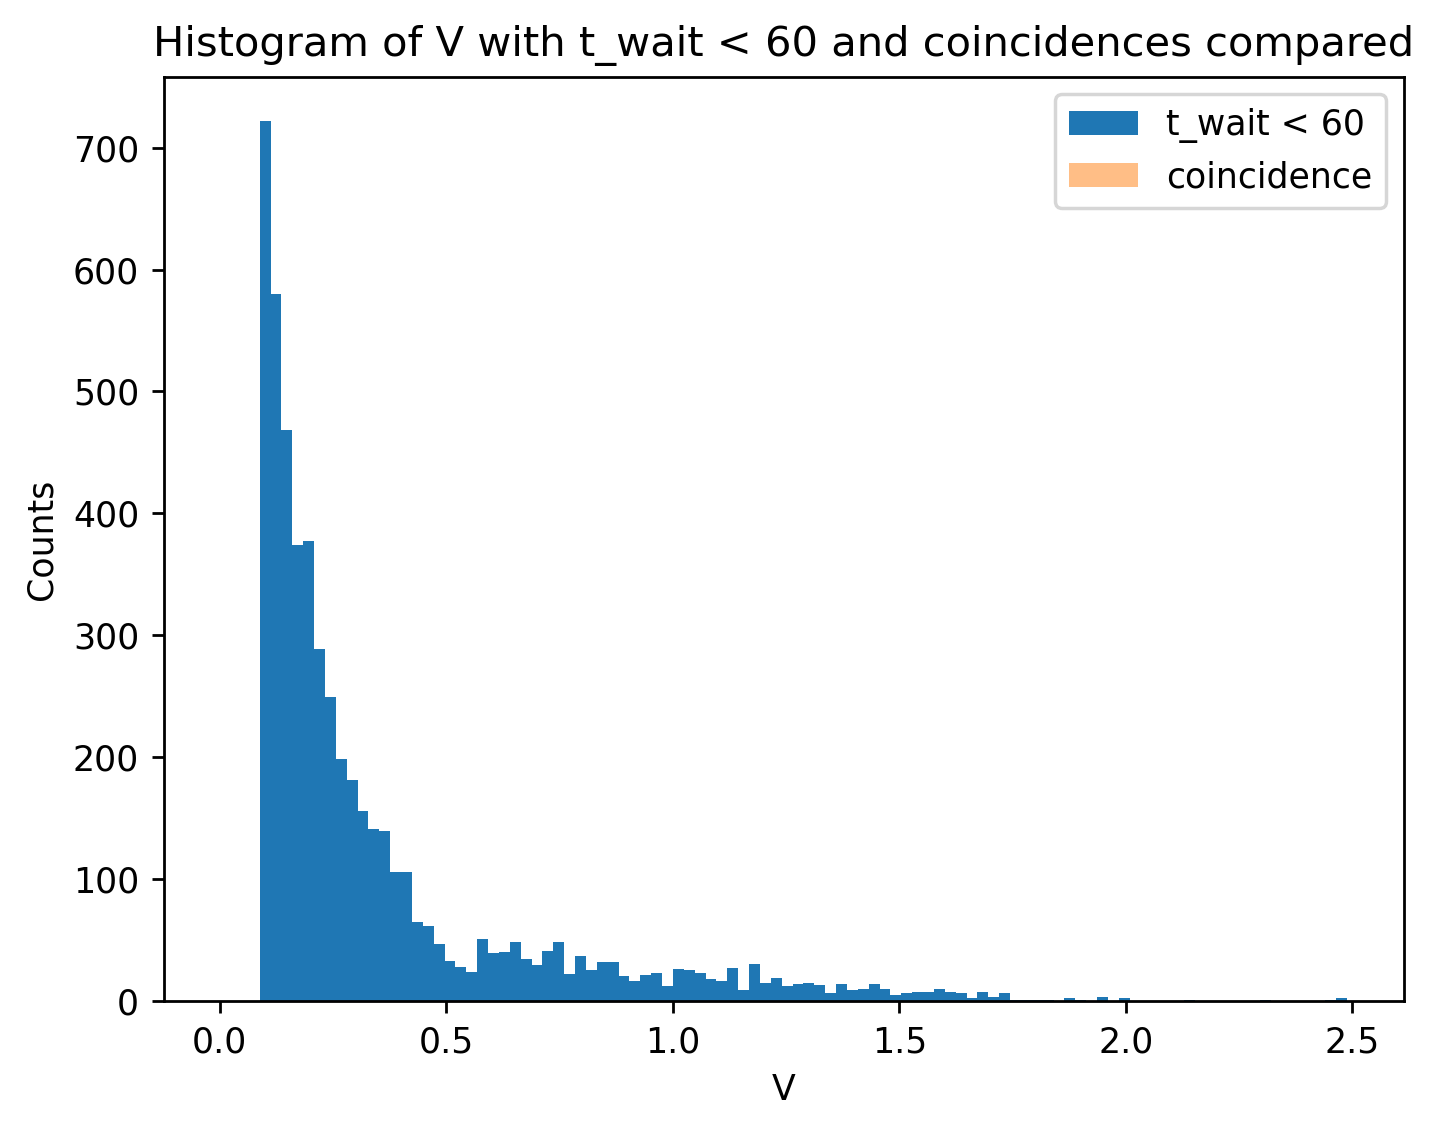

In [13]:
dfc['V'].plot.hist(bins=100)
dfcc['V'].plot.hist(bins=100, alpha=0.5)
plt.xlabel('V')
plt.ylabel('Counts')
plt.legend([f't_wait < {cut}', 'coincidence'])
plt.title(f'Histogram of V with t_wait < {cut} and coincidences compared')
plt.savefig('V_hist_coinc_twait.png')

Text(0.95, 0.95, 'Number of entries: 0')

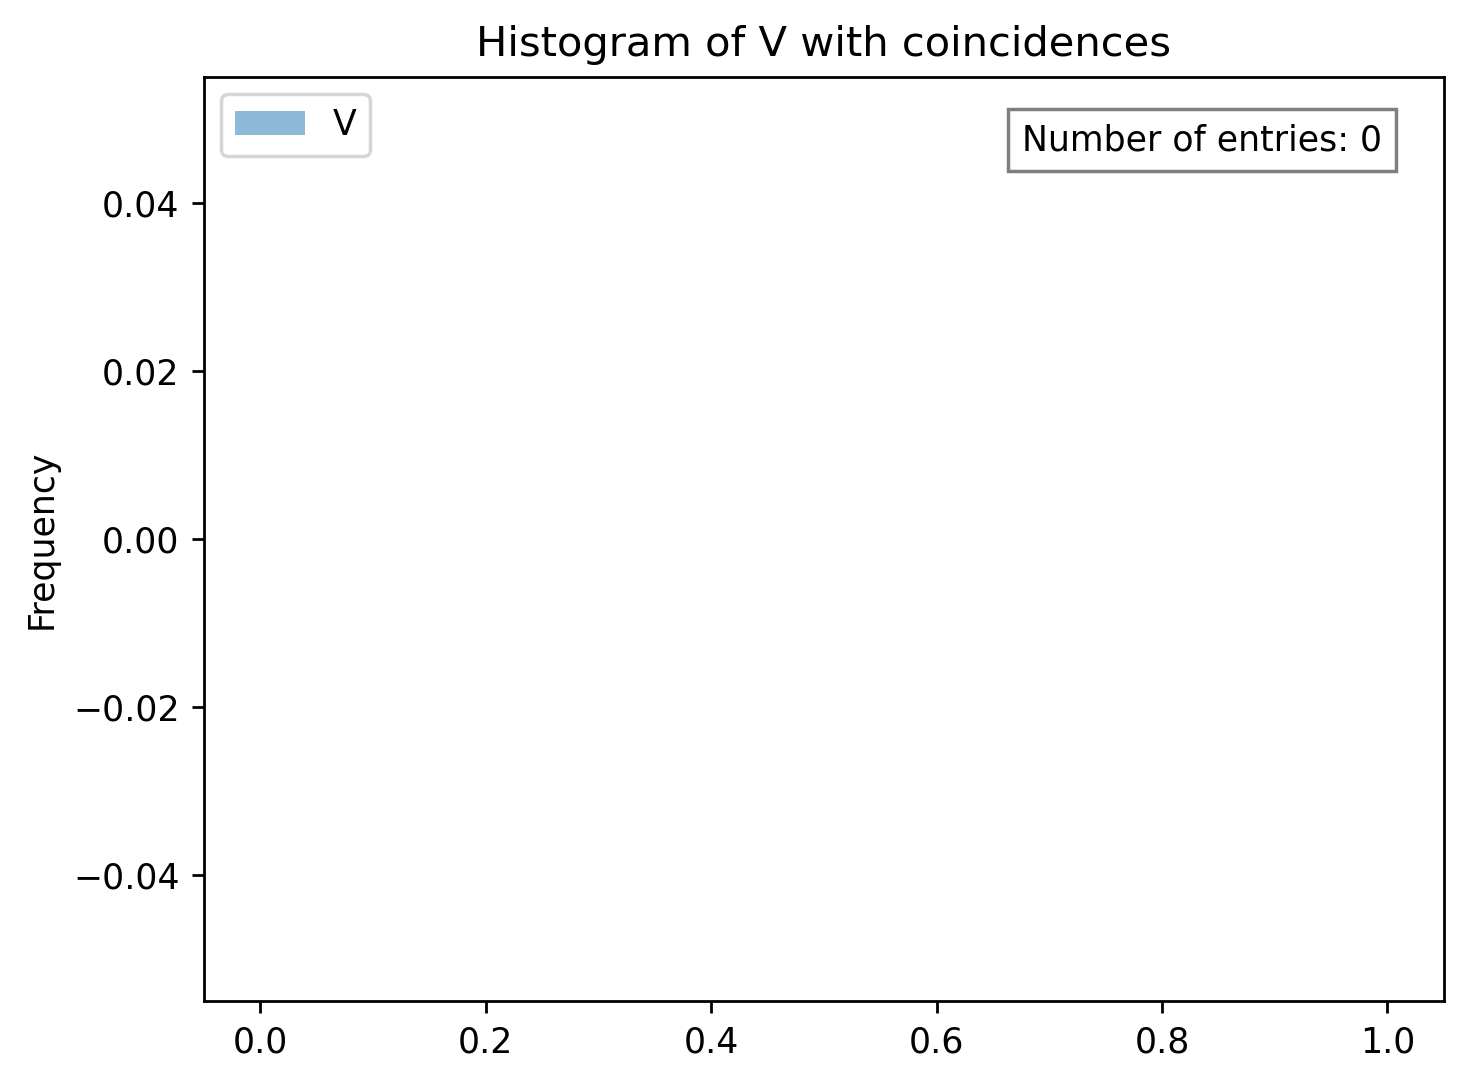

In [14]:
dfcc.plot.hist(y='V', bins=100, alpha=0.5, label='V')
plt.title('Histogram of V with coincidences')
ncount = len(dfcc)
plt.text(0.95, 0.95, f'Number of entries: {ncount}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

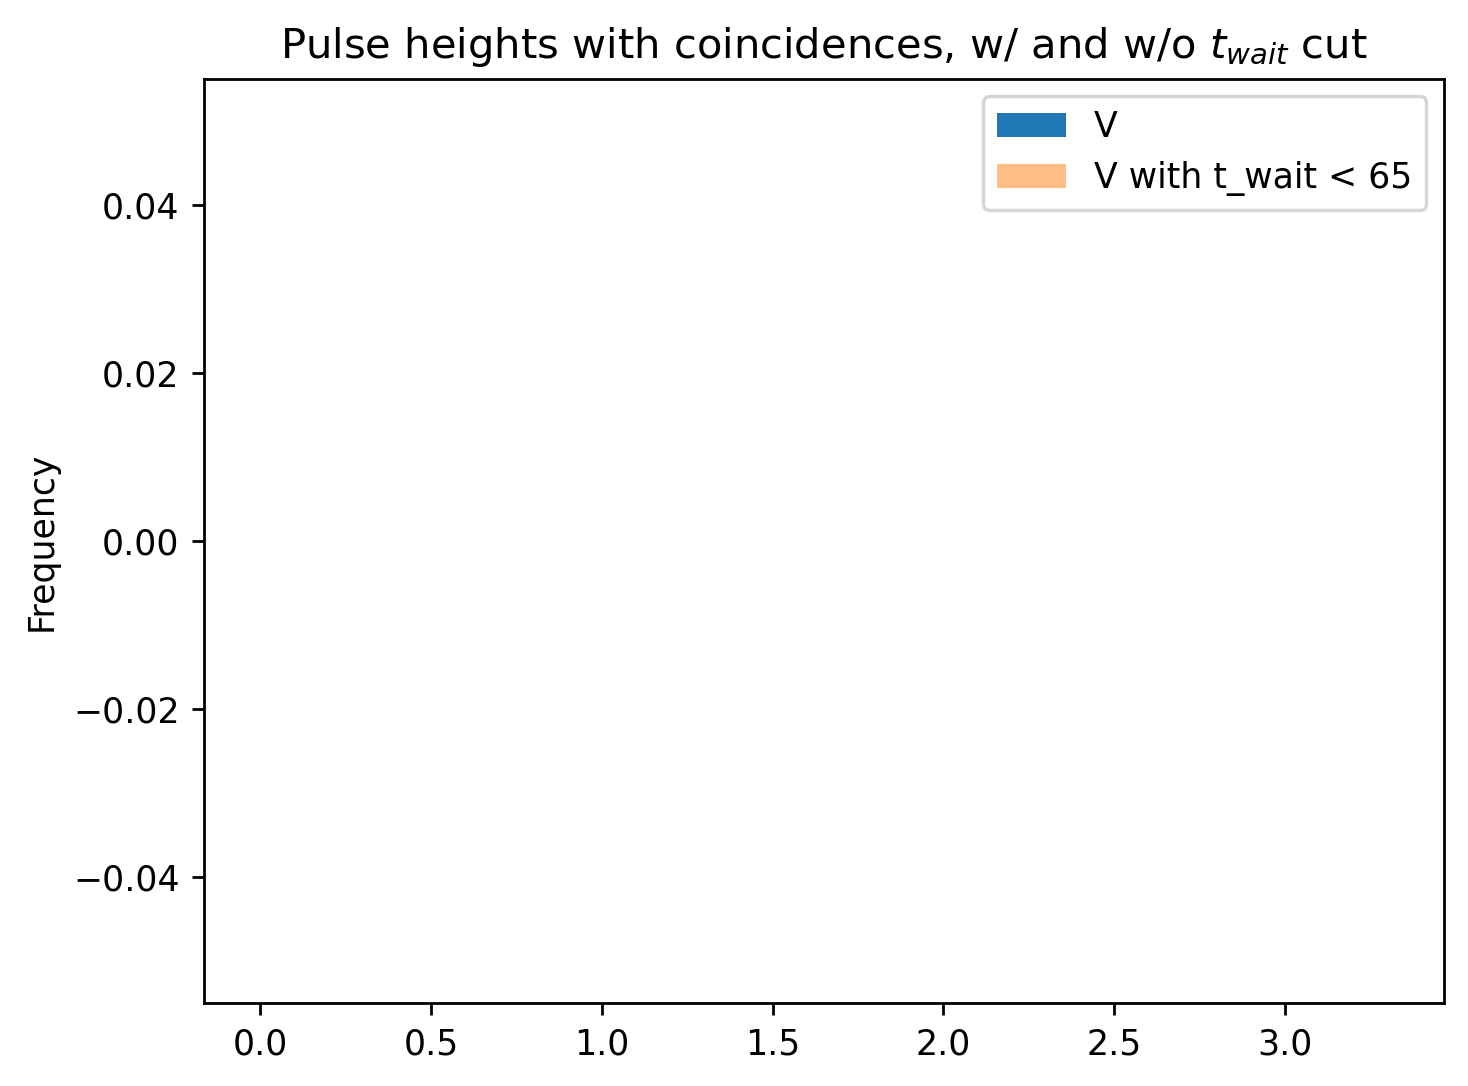

In [15]:
cut=65
dfcc['V'].plot.hist(label='V', bins=100, range=(0, 3.3))
dfcc[dfcc['t_wait']<cut]['V'].plot.hist(alpha=0.5, label=f'V with t_wait < {cut}', bins=100, range=(0, 3.3))
plt.legend()

plt.title('Pulse heights with coincidences, w/ and w/o $t_{wait}$ cut')
ncount = len(dfcc)


In [16]:
plt.figure(figsize=(10, 6))
tedges = np.linspace(30.5, 100.5, 71)
vedges = np.linspace(0, 3.3, 101)
plt.hist2d(dfcc['t_wait'], dfcc['V'], bins=[tedges, vedges],   norm=mcolors.LogNorm())
#plt.hist2d(dfc['t_wait'], dfc['V'], bins=[tedges, vedges],   norm=mcolors.LogNorm(), alpha=0.5)
plt.colorbar(label='Counts (log scale)')
plt.xlabel('$t_\\text{wait}$')
plt.ylabel('V')
plt.title('$t_\\text{wait}$ vs V, with coincidences')
plt.show()

ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x1696bab60> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 2500x1500 with 2 Axes>

# Rate calculation
Create a new dt column, now in seconds, to allow us to calculate the rate over time for coincidence and non-coincidence files.

In [ ]:
# create a new column with the time difference between entries, in seconds
dfcc['dt'] = dfcc.index.to_series().diff().dt.total_seconds()


# the original file had a dt column that was in microsenconds, so we need to convert that to seconds
if 'dt' in df.keys():
    df = df.drop(columns=['dt'])
df['dt'] = df.index.to_series().diff().dt.total_seconds()


In [ ]:
df['dt'].head()

In [ ]:
# calculate the average rate from the file
# the rate is the number of muons divided by the total time
# the total time is the last time minus the first time
total_time = (dfcc.index[-1]-dfcc.index[0]).total_seconds()
rate_coinc = len(dfcc)/total_time
print(total_time, rate_coinc)


In [ ]:
# calculate the average rate from the file
# the rate is the number of muons divided by the total time
# the total time is the last time minus the first time
total_time = (df.index[-1]-df.index[0]).total_seconds()
rate = len(df)/total_time
print(total_time, rate)


In [ ]:
dfcc['dt'].plot.hist(bins=100)
plt.xlabel('$\Delta t$ [s]')
plt.ylabel('Counts')
plt.title('Time differences between entries, coincidence mode')
mean_dt = dfcc['dt'].mean()
plt.text(0.95, 0.85, f'Mean dt: {mean_dt:.2f}s', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

In [ ]:
winsize=100
df['rolling_avg_rate'] = 1./(df['dt'].rolling(window=winsize).mean())
df['rolling_avg_rate'].tail()
print(df['rolling_avg_rate'].head(100))
df.dropna(inplace=True)
df['rolling_avg_rate'].plot()
# label y axis as Hz
plt.ylabel('Rate (Hz)')
plt.ylim(0,3)
plt.grid()
plt.title(f'Rolling average mean rate over {winsize} events, single')
plt.text(0.95, 0.85, f'Average rate: {rate:.2f} Hz', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.savefig('rolling_avg_rate_single.png')


In [ ]:
dfcc['rolling_avg_rate'] = 1./(dfcc['dt'].rolling(window=winsize).mean())
dfcc['rolling_avg_rate'].plot()
# label y axis as Hz
plt.ylabel('Rate (Hz)')
plt.ylim(0,.5)
plt.grid()
plt.title(f'Rolling average mean rate over {winsize} events')
plt.text(0.95, 0.85, f'Average rate: {rate_coinc:.2f} Hz', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.savefig('rolling_avg_rate_coinc.png')


In [ ]:
df['rolling_avg_rate'].plot(label='single')
dfcc['rolling_avg_rate'].plot(label='coincidence')
# label y axis as Hz
plt.ylabel('Rate (Hz)')
plt.ylim(0)
plt.grid()
plt.text(0.95, 0.25, f'Singles rate: {rate:.2f} Hz\nCoincidence rate: {rate_coinc:.2f} Hz', 
         horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.legend()

plt.title(f'Rolling average mean rate over {winsize} events')


Text(0.5, 1.0, 'Temperature vs time')

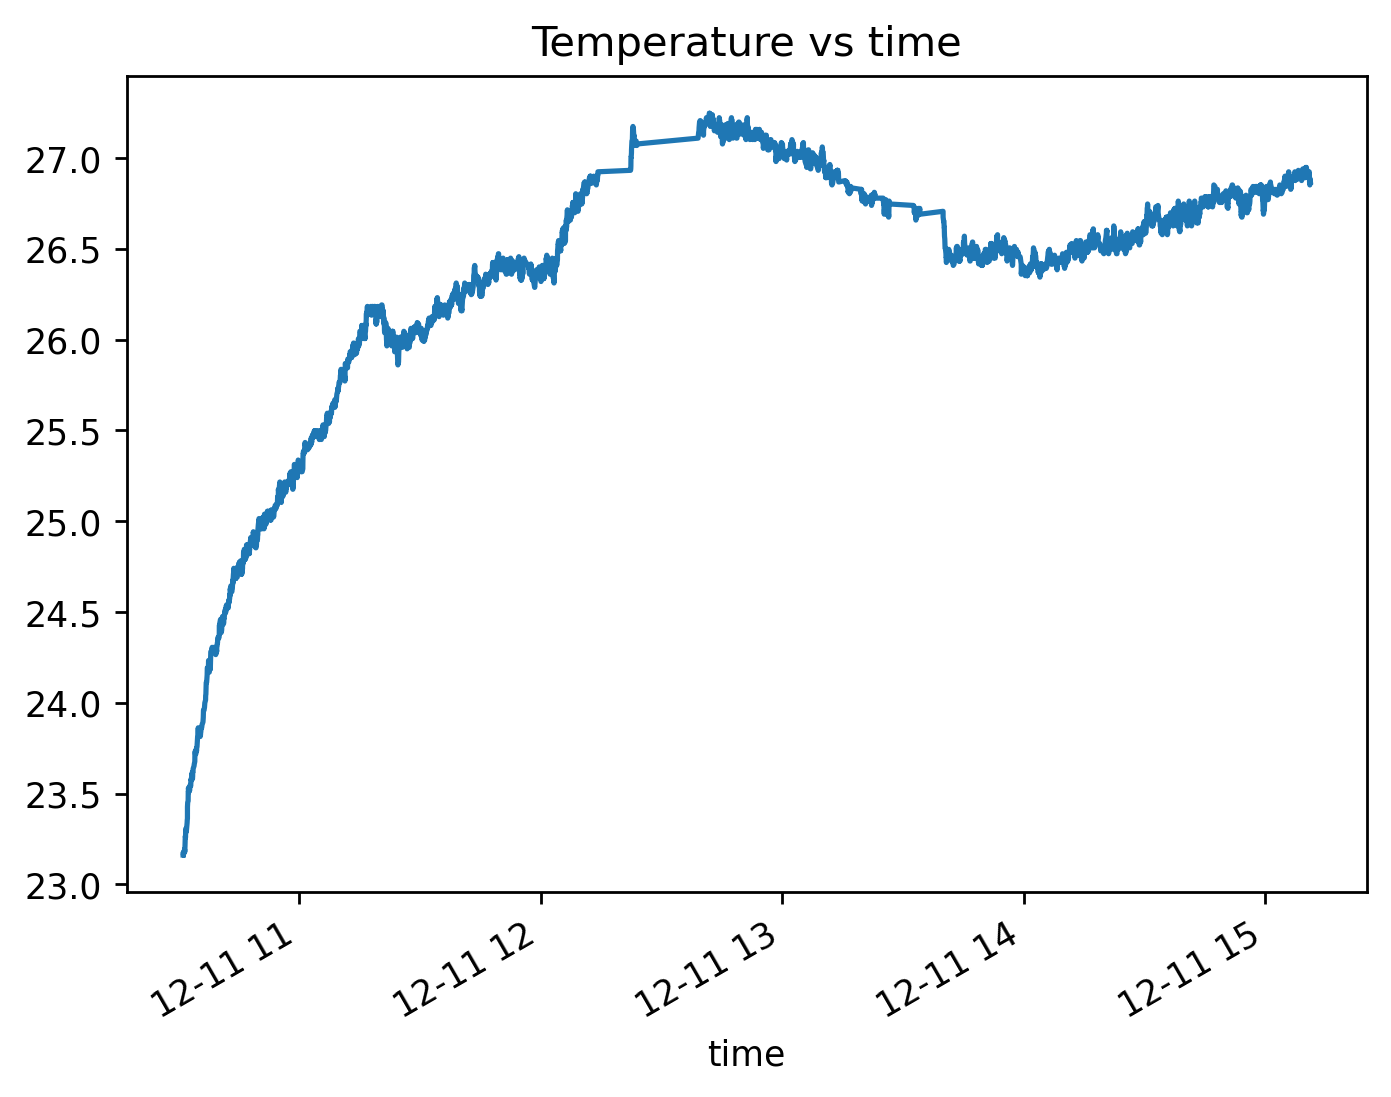

In [17]:
df['TempC'].rolling(window=10).mean().plot()
plt.title('Temperature vs time')